=== Tiền xử lý dữ liệu ===
Kích thước dữ liệu: (50191, 79)

Thông tin cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50191 entries, 0 to 50190
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    50191 non-null  object 
 1   year                                       50191 non-null  int64  
 2   iso_code                                   42262 non-null  object 
 3   population                                 41019 non-null  float64
 4   gdp                                        15251 non-null  float64
 5   cement_co2                                 28863 non-null  float64
 6   cement_co2_per_capita                      25358 non-null  float64
 7   co2                                        29137 non-null  float64
 8   co2_growth_abs                             26981 non-null  float64
 9   co2_growth_prct    

C:\Users\vunambac\AppData\Local\Temp\ipykernel_10176\659675791.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_countries['year'] = df_countries['year'].astype(int)


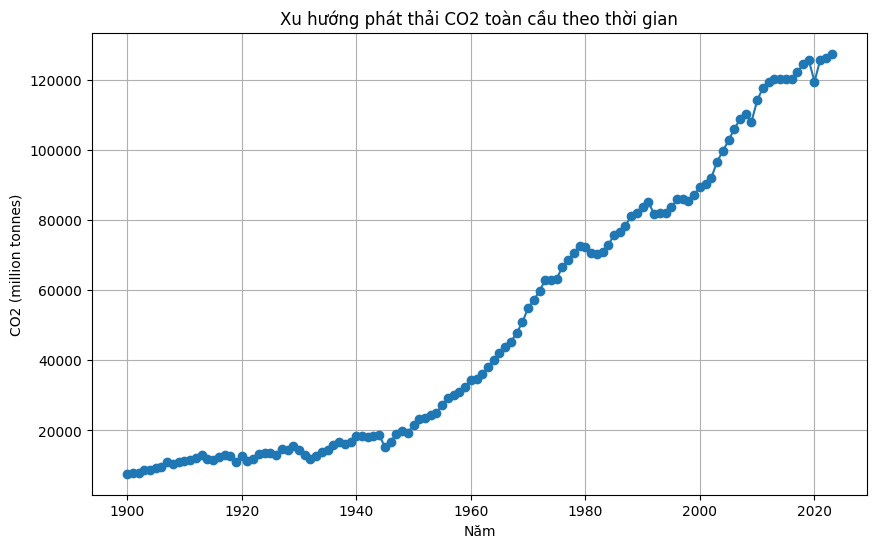

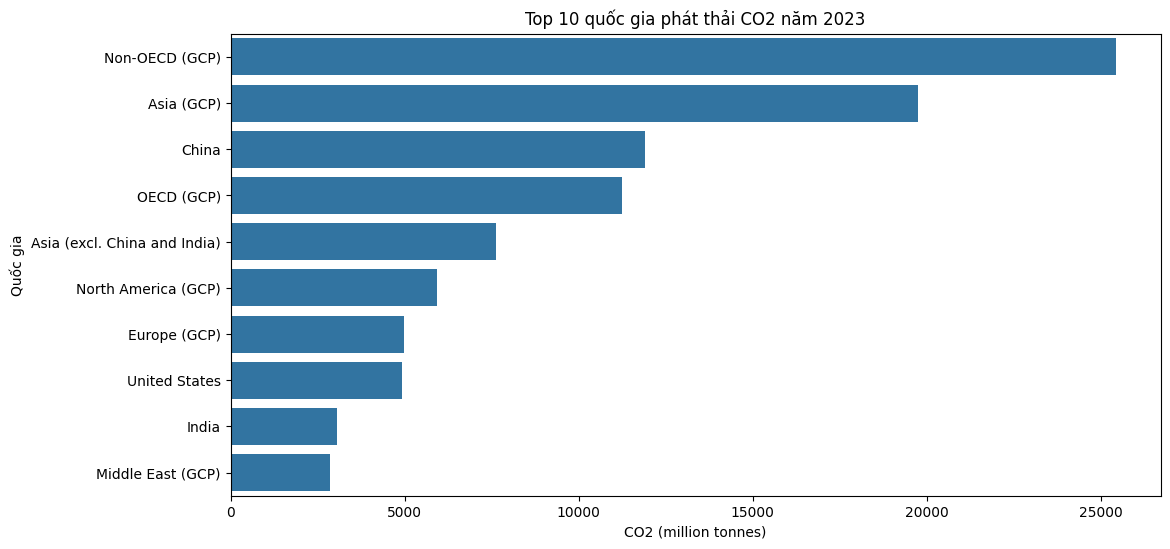

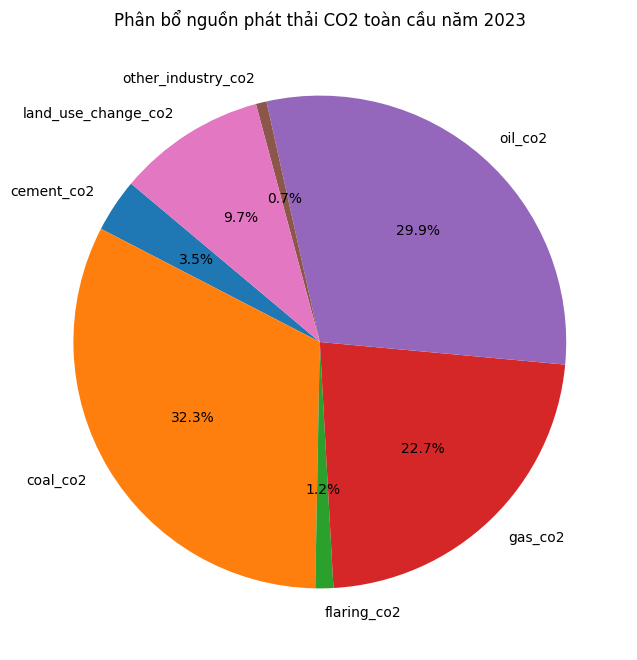

C:\Users\vunambac\AppData\Local\Temp\ipykernel_10176\659675791.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_latest['gdp_per_capita'] = df_latest['gdp'] / df_latest['population']


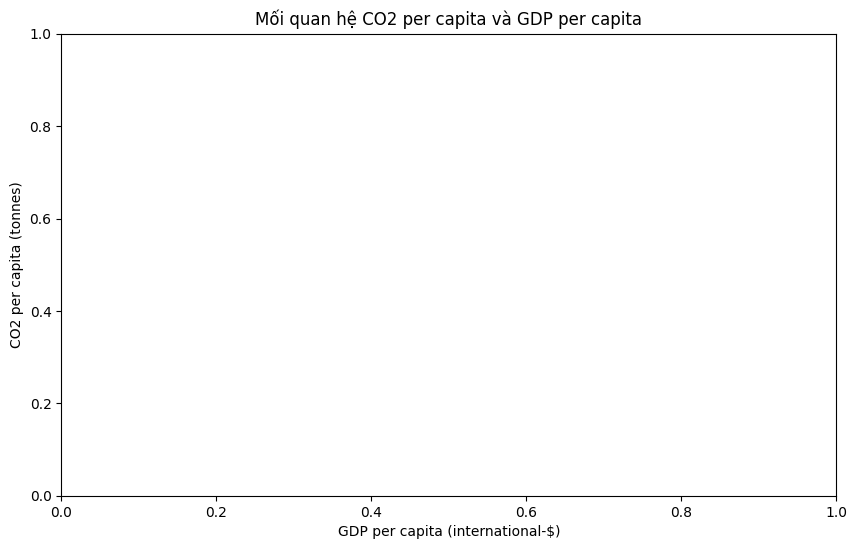

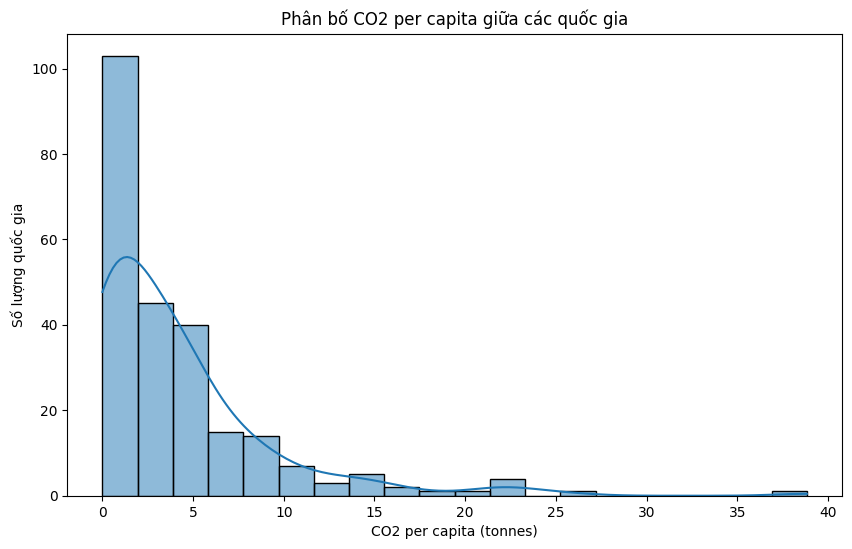

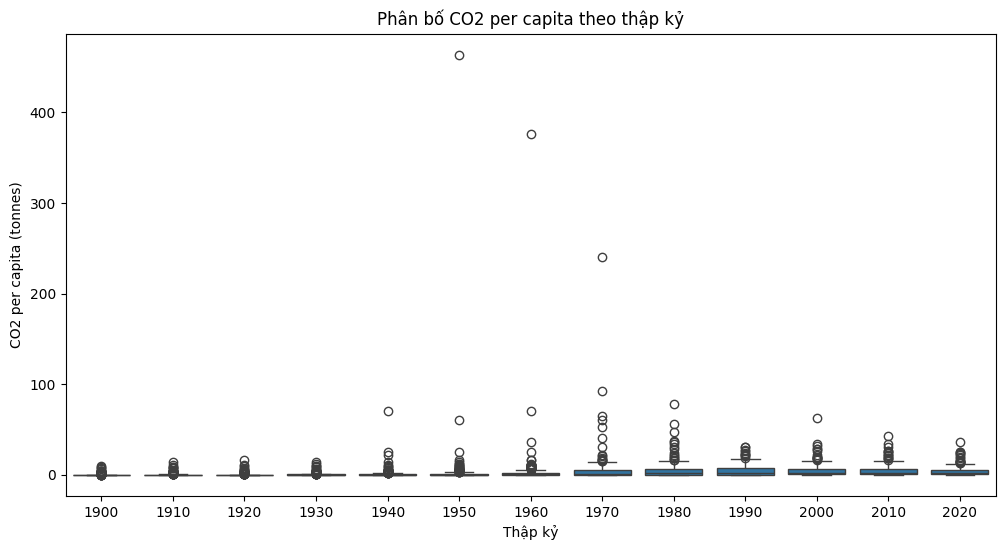

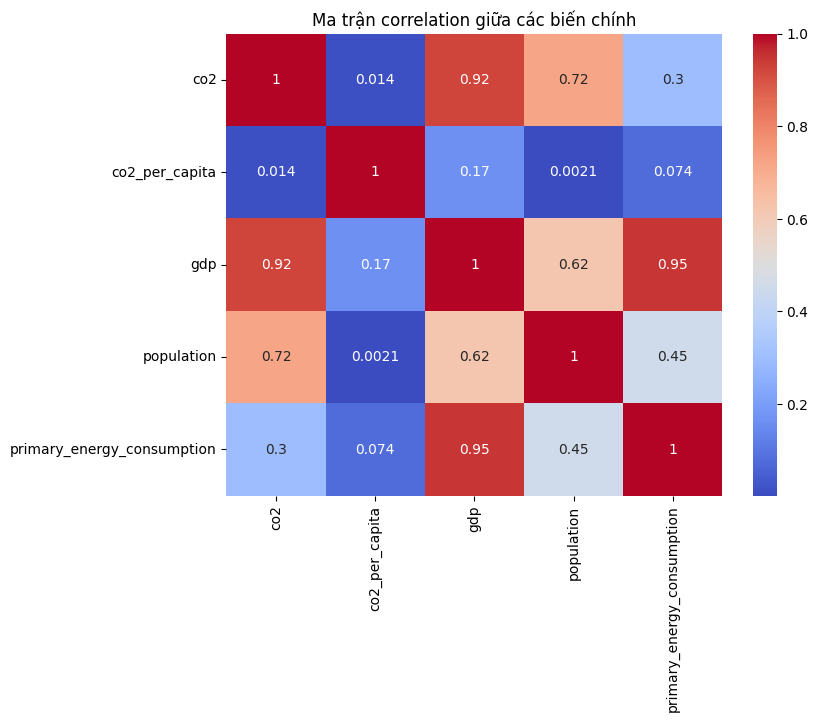

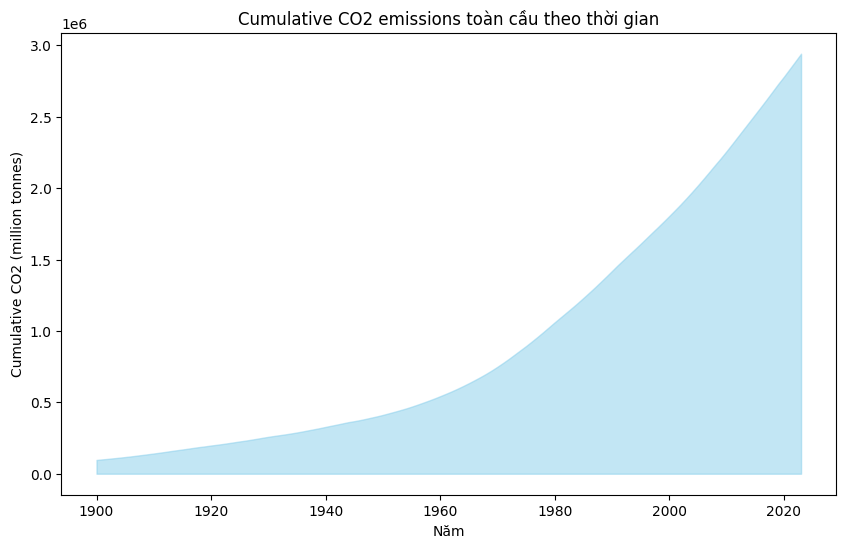

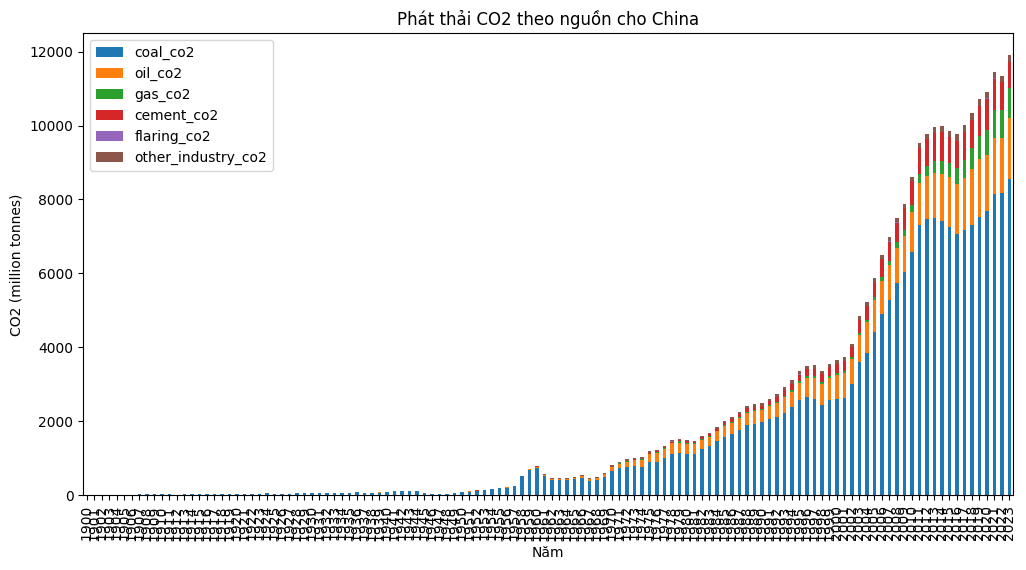

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_path = r'D:\project\visual\data\owid-co2-data.csv'

df = pd.read_csv(file_path)

print("Kích thước dữ liệu:", df.shape)
print("\nThông tin cột:")
print(df.info())
print("\nMẫu dữ liệu đầu tiên:")
print(df.head())

missing_values = df.isnull().sum()
print("\nGiá trị thiếu theo cột:")
print(missing_values[missing_values > 0])

# Xử lý giá trị thiếu: Điền 0 cho các cột emissions (giả định thiếu là 0), loại bỏ hàng thiếu country/year
df.fillna({col: 0 for col in df.columns if 'co2' in col or 'ghg' in col or 'energy' in col}, inplace=True)
df.dropna(subset=['country', 'year'], inplace=True)

# Lọc chỉ các quốc gia thực (loại bỏ aggregates như 'World', 'Asia', etc.)
aggregates = ['World', 'Asia', 'Europe', 'Africa', 'North America', 'South America', 'Oceania', 'High-income countries', 'Low-income countries', 'Lower-middle-income countries', 'Upper-middle-income countries', 'European Union (27)', 'International transport']
df_countries = df[~df['country'].isin(aggregates)]

# Chuyển đổi kiểu dữ liệu nếu cần (year thành int)
df_countries['year'] = df_countries['year'].astype(int)

# Giới hạn dữ liệu từ năm 1900 để tập trung vào hiện đại (tùy chọn)
df_countries = df_countries[df_countries['year'] >= 1900]

print("\nDữ liệu sau tiền xử lý (chỉ quốc gia):", df_countries.shape)


# Thống kê mô tả cho các cột chính
main_cols = ['co2', 'co2_per_capita', 'gdp', 'population', 'primary_energy_consumption']
print("\nThống kê mô tả:")
print(df_countries[main_cols].describe())

# Top 10 quốc gia phát thải CO2 cao nhất năm gần nhất (2023 hoặc max year)
latest_year = df_countries['year'].max()
df_latest = df_countries[df_countries['year'] == latest_year]
top_emitters = df_latest.sort_values('co2', ascending=False).head(10)
print("\nTop 10 quốc gia phát thải CO2 cao nhất năm", latest_year, ":")
print(top_emitters[['country', 'co2', 'co2_per_capita']])

# Tăng trưởng CO2 trung bình theo thập kỷ
df_countries['decade'] = (df_countries['year'] // 10) * 10
growth_by_decade = df_countries.groupby('decade')['co2_growth_prct'].mean().reset_index()
print("\nTăng trưởng CO2 trung bình theo thập kỷ:")
print(growth_by_decade)

# Correlation giữa các biến
corr_matrix = df_countries[main_cols].corr()
print("\nMa trận correlation:")
print(corr_matrix)


output_dir = 'co2_visualizations'
os.makedirs(output_dir, exist_ok=True)

# Line plot: Xu hướng CO2 toàn cầu theo thời gian (tổng hợp từ quốc gia)
global_co2_trend = df_countries.groupby('year')['co2'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(global_co2_trend['year'], global_co2_trend['co2'], marker='o')
plt.title('Xu hướng phát thải CO2 toàn cầu theo thời gian')
plt.xlabel('Năm')
plt.ylabel('CO2 (million tonnes)')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'global_co2_trend_line.png'))
plt.show()

# Bar chart: Top 10 emitters năm gần nhất
plt.figure(figsize=(12, 6))
sns.barplot(x='co2', y='country', data=top_emitters)
plt.title(f'Top 10 quốc gia phát thải CO2 năm {latest_year}')
plt.xlabel('CO2 (million tonnes)')
plt.ylabel('Quốc gia')
plt.savefig(os.path.join(output_dir, 'top_emitters_bar.png'))
plt.show()

# Pie chart: Phân bổ nguồn phát thải cho thế giới năm gần nhất (tổng hợp)
global_latest = df_latest.sum(numeric_only=True)
sources = ['cement_co2', 'coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2', 'other_industry_co2', 'land_use_change_co2']
source_values = global_latest[sources]
plt.figure(figsize=(8, 8))
plt.pie(source_values, labels=sources, autopct='%1.1f%%', startangle=140)
plt.title(f'Phân bổ nguồn phát thải CO2 toàn cầu năm {latest_year}')
plt.savefig(os.path.join(output_dir, 'source_pie.png'))
plt.show()

# Scatter plot: CO2 per capita vs GDP per capita năm gần nhất
df_latest['gdp_per_capita'] = df_latest['gdp'] / df_latest['population']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gdp_per_capita', y='co2_per_capita', data=df_latest, hue='country', legend=False)
plt.title('Mối quan hệ CO2_per capita và GDP per capita')
plt.xlabel('GDP per capita (international-$)')
plt.ylabel('CO2 per capita (tonnes)')
plt.savefig(os.path.join(output_dir, 'co2_vs_gdp_scatter.png'))
plt.show()

# Histogram: Phân bố CO2 per capita năm gần nhất
plt.figure(figsize=(10, 6))
sns.histplot(df_latest['co2_per_capita'], bins=20, kde=True)
plt.title('Phân bố CO2 per capita giữa các quốc gia')
plt.xlabel('CO2 per capita (tonnes)')
plt.ylabel('Số lượng quốc gia')
plt.savefig(os.path.join(output_dir, 'co2_per_capita_hist.png'))
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='co2_per_capita', data=df_countries[df_countries['year'] % 10 == 0])  # Mỗi thập kỷ
plt.title('Phân bố CO2_per_capita theo thập kỷ')
plt.xlabel('Thập kỷ')
plt.ylabel('CO2_per_capita (tonnes)')
plt.savefig(os.path.join(output_dir, 'co2_per_capita_box.png'))
plt.show()

# Heatmap: Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Ma trận correlation giữa các biến chính')
plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'))
plt.show()

# Area chart: Cumulative CO2 theo thời gian toàn cầu
global_cumulative = df_countries.groupby('year')['cumulative_co2'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.fill_between(global_cumulative['year'], global_cumulative['cumulative_co2'], color='skyblue', alpha=0.5)
plt.title('Cumulative CO2 emissions toàn cầu theo thời gian')
plt.xlabel('Năm')
plt.ylabel('Cumulative CO2 (million tonnes)')
plt.savefig(os.path.join(output_dir, 'cumulative_co2_area.png'))
plt.show()

# Stacked bar: Phát thải theo nguồn cho một quốc gia (ví dụ: China)
country_example = 'China'
df_country = df_countries[df_countries['country'] == country_example]
sources_over_time = df_country[['year', 'coal_co2', 'oil_co2', 'gas_co2', 'cement_co2', 'flaring_co2', 'other_industry_co2']]
sources_over_time.set_index('year').plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title(f'Phát thải CO2 theo nguồn cho {country_example}')
plt.xlabel('Năm')
plt.ylabel('CO2 (million tonnes)')
plt.savefig(os.path.join(output_dir, 'stacked_bar_sources.png'))
plt.show()



từ bảng trên cho thấy lượng co2 tích lũy qua từng năm trên trái đất tăng dần đều và không có dấu hiệu giảm, là một vấn đề đáng báo động 

In [ ]:
import pandas as pd
import plotly.express as px

df = df[df["iso_code"].str.len() == 3]


fig = px.choropleth(
    df,
    locations="iso_code",                 
    color="co2_including_luc",           
    hover_name="country",                 
    animation_frame="year",               
    color_continuous_scale="YlOrBr",     
    range_color=(0, df["co2_including_luc"].max()), 
    title="Annual CO₂ emissions including land-use change (1850–2023)",
    labels={"co2_including_luc": "Million tonnes CO₂"}
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px


countries = [
    "United States",
    "Canada",
    "China",
    "South Africa",
    "European Union (27)",
    "World",
    "United Kingdom",
    "India",
    "Kenya"
]

df_filtered = df[df["country"].isin(countries)]

fig = px.line(
    df_filtered,
    x="year",
    y="co2_per_capital",
    color="country",
    title="CO₂ emissions per capita (1750–2023)",
    labels={"co2_per_capita": "Tonnes CO₂ per person", "year": "Year"}
)

fig.show()


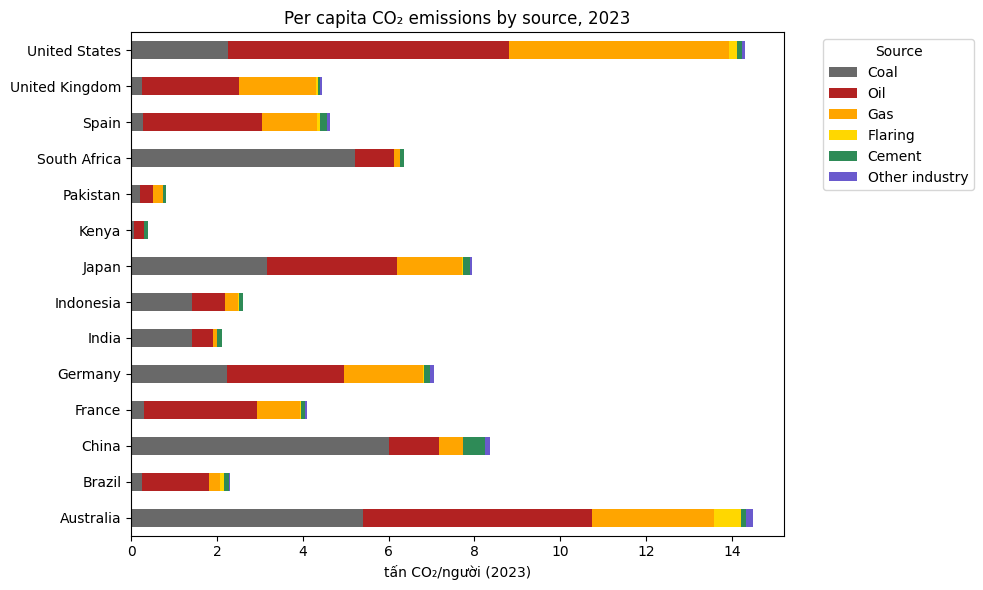

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

countries = [
    "Australia", "United States", "China", "Japan", "Germany", "South Africa",
    "World", "Spain", "United Kingdom", "France", "Indonesia", "Brazil",
    "India", "Pakistan", "Kenya"
]
df_2023 = df[(df["year"] == 2023) & (df["country"].isin(countries))]

sources = {
    "Coal": "coal_co2_per_capita",
    "Oil": "oil_co2_per_capita",
    "Gas": "gas_co2_per_capita",
    "Flaring": "flaring_co2_per_capita",
    "Cement": "cement_co2_per_capita",
    "Other industry": "other_co2_per_capita"
}

data = df_2023.set_index("country")[list(sources.values())].fillna(0)
data = data.rename(columns={v: k for k, v in sources.items()})

colors = {
    "Coal": "dimgray",
    "Oil": "firebrick",
    "Gas": "orange",
    "Flaring": "gold",
    "Cement": "seagreen",
    "Other industry": "slateblue"
}

ax = data.plot(
    kind="barh",
    stacked=True,
    color=[colors[col] for col in data.columns],
    figsize=(10, 6)
)

plt.xlabel("tấn CO₂/người (2023)")
plt.ylabel("")
plt.title("Per capita CO₂ emissions by source, 2023")
plt.legend(title="Source", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


từ biểu đồ ta thấy ở các nước lớn phát thải co2 chủ yếu qua 3 nguồn chính coal, oil và gas cho ta thấy cách các nền kinh tế vận hành phụ thuộc vào năng lượng ra sao 
